# Jellyfish 종 구분하기!

## 모델 학습을 위한 데이터셋 준비하기

In [1]:
# 경고 메시지 출력 방지
import warnings
warnings.filterwarnings("ignore")

In [2]:
# 필요한 라이브러리 불러오기
import os
import cv2
import numpy as np
import tensorflow as tf
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, GlobalAveragePooling2D
from keras.layers import BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE

IMAGE_SIZE = [224, 224]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/Train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/valid/*/*'
TEST_PATH = ROOT_PATH + '/jellyfish/Train_Test_Valid/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 32
EPOCHS = 10

In [4]:
# 데이터 불러오기
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

900
40
39


In [5]:
import random, math
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

751
188


In [6]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [7]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 751
Validating images count: 188


In [8]:
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)

    if parts[-2] == "barrel_jellyfish":
        return 0   # barrel_jellyfish이면 라벨 0

    elif parts[-2] == "blue_jellyfish":
        return 1   # blue_jellyfish이면 라벨 1

    elif parts[-2] == "compass_jellyfish":
        return 2   # compass_jellyfish이면 라벨 2

    elif parts[-2] == "lions_mane_jellyfish":
        return 3   # lions_mane_jellyfish이면 라벨 3

    elif parts[-2] == "mauve_stinger_jellyfish":
        return 4   # mauve_stinger_jellyfish이면 라벨 4

    else :
        return 5  # Moon_jellyfish이면 라벨 5

In [9]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [10]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [11]:
# 이미지 리사이즈 결과, 레이블 확인
for image, label in train_ds.take(1): # 하나의 데이터만 가져온다
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  3


In [12]:
# test dataset 만들기
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

40


In [13]:
# augmentation function
def augment(img, label):
    # Randomly flip left or right
    img = tf.image.random_flip_left_right(img)
       
    img = tf.image.random_saturation(img, lower=0.5, upper=1.5)

    img = tf.image.rot90(img, tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    
    return img,label

In [14]:
def prepare_for_training(ds, shuffle_buffer_size=256):
    ds = ds.map(augment, num_parallel_calls=AUTOTUNE)
    
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_bat = prepare_for_training(train_ds)
val_bat = prepare_for_training(val_ds)
test_bat = test_ds.batch(BATCH_SIZE)

In [106]:
# 모델 작업
from tensorflow.keras.regularizers import l2
import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 224, 224, 16)      448       
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 112, 112, 32)      4640      
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 56, 56, 64)        18496     
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 28, 28, 64)       

In [107]:
# 모델 complie
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [108]:
# 모델 학습
history = model.fit(train_bat, 
                    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                    epochs=50, 
                    validation_data=val_bat,
                    validation_steps=VAL_IMG_COUNT // BATCH_SIZE)

Epoch 1/50
46/46 [==============================] - 3s 41ms/step - loss: 1.7792 - accuracy: 0.2106 - val_loss: 1.6904 - val_accuracy: 0.2386
Epoch 2/50
46/46 [==============================] - 2s 37ms/step - loss: 1.7051 - accuracy: 0.2378 - val_loss: 1.6433 - val_accuracy: 0.2386
Epoch 3/50
46/46 [==============================] - 2s 36ms/step - loss: 1.6484 - accuracy: 0.2745 - val_loss: 1.6025 - val_accuracy: 0.2386
Epoch 4/50
46/46 [==============================] - 2s 35ms/step - loss: 1.5708 - accuracy: 0.2799 - val_loss: 1.5273 - val_accuracy: 0.3011
Epoch 5/50
46/46 [==============================] - 2s 40ms/step - loss: 1.4928 - accuracy: 0.3356 - val_loss: 1.4332 - val_accuracy: 0.3352
Epoch 6/50
46/46 [==============================] - 2s 35ms/step - loss: 1.4111 - accuracy: 0.3641 - val_loss: 1.3822 - val_accuracy: 0.3125
Epoch 7/50
46/46 [==============================] - 2s 36ms/step - loss: 1.3691 - accuracy: 0.4185 - val_loss: 1.3808 - val_accuracy: 0.4034
Epoch 8/50
46

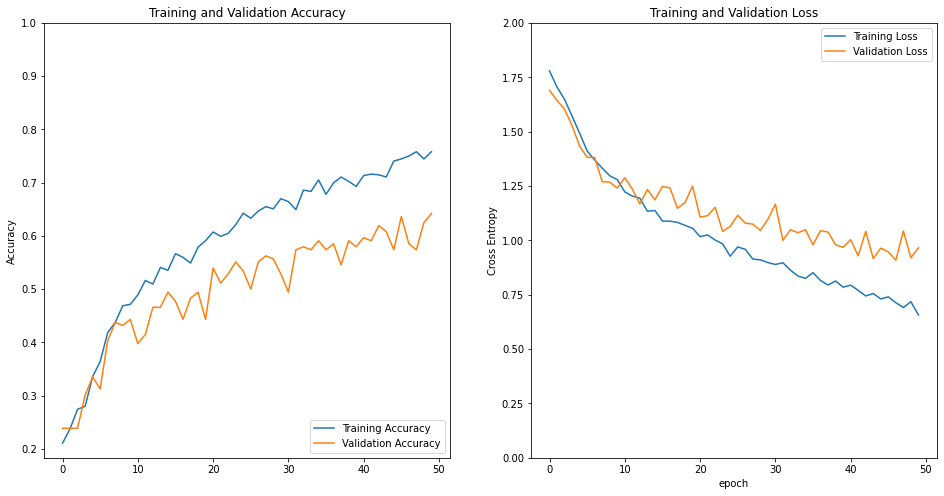

In [109]:
# 그래프로 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [110]:
test_performance = model.evaluate(test_ds)

print("Test Loss: ", test_performance[0])
print("Test Accuracy: ", test_performance[1])

3/3 [==============================] - 0s 7ms/step - loss: 1.1798 - accuracy: 0.6000
Test Loss:  1.1798286437988281
Test Accuracy:  0.6000000238418579


## 모델 컴파일 변경

In [90]:
# 모델 complie
base_learning_rate = 0.00011
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [91]:
# 모델 학습
history = model.fit(train_bat, 
                    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                    epochs=30, 
                    validation_data=val_bat,
                    validation_steps=VAL_IMG_COUNT // BATCH_SIZE)

Epoch 1/30
46/46 [==============================] - 3s 41ms/step - loss: 1.1263 - accuracy: 0.5897 - val_loss: 1.1899 - val_accuracy: 0.5398
Epoch 2/30
46/46 [==============================] - 2s 37ms/step - loss: 1.1170 - accuracy: 0.5720 - val_loss: 1.2125 - val_accuracy: 0.5398
Epoch 3/30
46/46 [==============================] - 2s 38ms/step - loss: 1.0709 - accuracy: 0.5788 - val_loss: 1.1434 - val_accuracy: 0.5511
Epoch 4/30
46/46 [==============================] - 2s 40ms/step - loss: 1.0786 - accuracy: 0.5774 - val_loss: 1.1700 - val_accuracy: 0.5625
Epoch 5/30
46/46 [==============================] - 2s 36ms/step - loss: 1.0540 - accuracy: 0.6114 - val_loss: 1.2130 - val_accuracy: 0.4773
Epoch 6/30
46/46 [==============================] - 2s 36ms/step - loss: 1.0064 - accuracy: 0.6168 - val_loss: 1.1211 - val_accuracy: 0.5795
Epoch 7/30
46/46 [==============================] - 2s 34ms/step - loss: 1.0433 - accuracy: 0.6250 - val_loss: 1.2073 - val_accuracy: 0.5455
Epoch 8/30
46

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7ffa1c5edb80>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


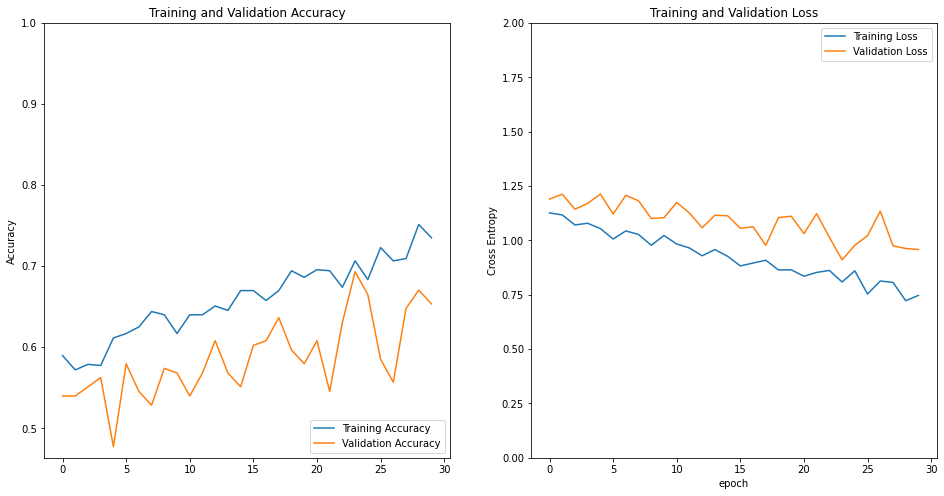

In [93]:
# 그래프로 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [96]:
test_performance = model.evaluate(test_ds)

print("Test Loss: ", test_performance[0])
print("Test Accuracy: ", test_performance[1])

3/3 [==============================] - 0s 7ms/step - loss: 0.9893 - accuracy: 0.5750
Test Loss:  0.9892978668212891
Test Accuracy:  0.574999988079071


## 모델 kernel size 변경

In [16]:
# 모델 작업
import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (2,2), padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (2,2), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (2,2), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (1,1), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        4

In [17]:
# 모델 complie
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [18]:
# 모델 학습
history = model.fit(train_bat, 
                    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                    epochs=100, 
                    validation_data=val_bat,
                    validation_steps=VAL_IMG_COUNT // BATCH_SIZE)

Epoch 1/100
23/23 [==============================] - 46s 88ms/step - loss: 2.1939 - accuracy: 0.1685 - val_loss: 1.7908 - val_accuracy: 0.1875
Epoch 2/100
23/23 [==============================] - 1s 50ms/step - loss: 1.8123 - accuracy: 0.1277 - val_loss: 1.7959 - val_accuracy: 0.1625
Epoch 3/100
23/23 [==============================] - 1s 44ms/step - loss: 1.8103 - accuracy: 0.1875 - val_loss: 1.7822 - val_accuracy: 0.1875
Epoch 4/100
23/23 [==============================] - 1s 44ms/step - loss: 1.7917 - accuracy: 0.1848 - val_loss: 1.7939 - val_accuracy: 0.1125
Epoch 5/100
23/23 [==============================] - 1s 44ms/step - loss: 1.8325 - accuracy: 0.2473 - val_loss: 1.7917 - val_accuracy: 0.1250
Epoch 6/100
23/23 [==============================] - 1s 45ms/step - loss: 1.7778 - accuracy: 0.1848 - val_loss: 1.7986 - val_accuracy: 0.1125
Epoch 7/100
23/23 [==============================] - 1s 45ms/step - loss: 1.7943 - accuracy: 0.2120 - val_loss: 1.7915 - val_accuracy: 0.1000
Epoch

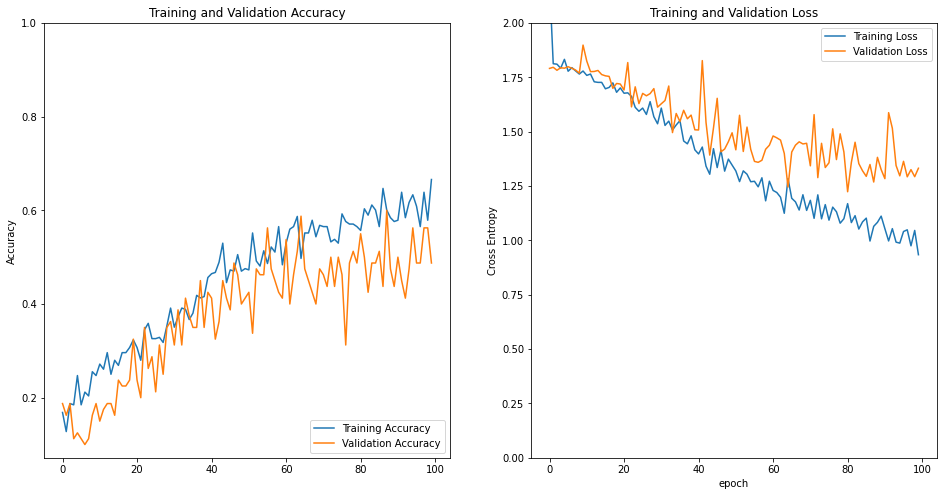

In [19]:
# 그래프로 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [20]:
test_performance = model.evaluate(test_ds)

print("Test Loss: ", test_performance[0])
print("Test Accuracy: ", test_performance[1])

3/3 [==============================] - 0s 99ms/step - loss: 1.3138 - accuracy: 0.4750
Test Loss:  1.313780665397644
Test Accuracy:  0.4749999940395355


## batch_size 및 모델 구조 변경

In [21]:
# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16

In [22]:
# 모델 작업
import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (2,2), padding='same', activation='relu', kernel_initializer='he_normal', input_shape=(224,224,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (2,2), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (2,2), padding='same', activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(16, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.Dense(6, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 56, 56, 64)        8256      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 28, 28, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50176)            

In [23]:
# 모델 complie
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [24]:
# 모델 학습
history = model.fit(train_bat, 
                    steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
                    epochs=100, 
                    validation_data=val_bat,
                    validation_steps=VAL_IMG_COUNT // BATCH_SIZE)

Epoch 1/100
46/46 [==============================] - 3s 38ms/step - loss: 1.8137 - accuracy: 0.2160 - val_loss: 1.7235 - val_accuracy: 0.3125
Epoch 2/100
46/46 [==============================] - 2s 35ms/step - loss: 1.6978 - accuracy: 0.2541 - val_loss: 1.7032 - val_accuracy: 0.2500
Epoch 3/100
46/46 [==============================] - 2s 34ms/step - loss: 1.6287 - accuracy: 0.3166 - val_loss: 1.6599 - val_accuracy: 0.3182
Epoch 4/100
46/46 [==============================] - 2s 38ms/step - loss: 1.5694 - accuracy: 0.3736 - val_loss: 1.6399 - val_accuracy: 0.3239
Epoch 5/100
46/46 [==============================] - 2s 34ms/step - loss: 1.5587 - accuracy: 0.3519 - val_loss: 1.6148 - val_accuracy: 0.3239
Epoch 6/100
46/46 [==============================] - 2s 34ms/step - loss: 1.5265 - accuracy: 0.3940 - val_loss: 1.5400 - val_accuracy: 0.3807
Epoch 7/100
46/46 [==============================] - 2s 35ms/step - loss: 1.4981 - accuracy: 0.3940 - val_loss: 1.6526 - val_accuracy: 0.3182
Epoch 

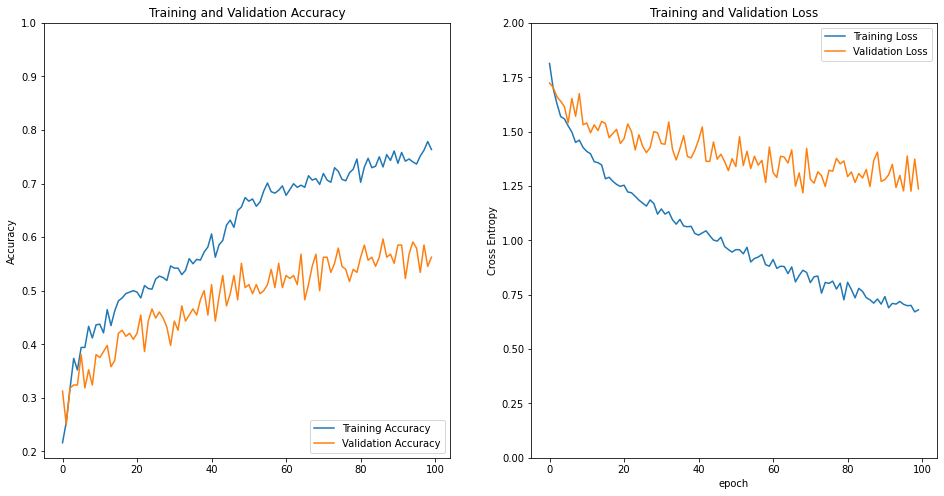

In [25]:
# 그래프로 확인
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [26]:
test_performance = model.evaluate(test_ds)

print("Test Loss: ", test_performance[0])
print("Test Accuracy: ", test_performance[1])

3/3 [==============================] - 0s 8ms/step - loss: 1.0437 - accuracy: 0.6750
Test Loss:  1.0436590909957886
Test Accuracy:  0.675000011920929
